In [1]:
import numpy as np 
import pandas as pd 
import scipy.sparse as sp
from itertools import islice, cycle, product
from more_itertools import pairwise
import copy

import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

from collections import Counter

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        
import pickle

In [2]:
df = pd.read_csv('input/interactions.csv')
df_users = pd.read_csv('input/users.csv')
df_items = pd.read_csv('input/items.csv')
submit = pd.read_csv('input/sample_submission.csv')

# Preprocessing
### Interaсtions

In [3]:
df['start_date']= pd.to_datetime(df.start_date)
assert (df.start_date.dt.month.unique() == np.arange(1,13)).all()
print(f'df ini.shape: {df.shape}')

duplicates = df.duplicated(subset=['user_id', 'item_id'], keep=False)
df_duplicates = df[duplicates].sort_values(by=['user_id', 'item_id'])
print(f'df_duplicates ini.shape: {df_duplicates.shape}')

df = df[~duplicates]

df_duplicates = df_duplicates.groupby(['user_id', 'item_id']).agg({
                                        'progress': 'max',
                                        'rating': 'max',
                                        'start_date': 'min'
                                        })
print(f'df_duplicates after agg.shape: {df_duplicates.shape}')
df = df.append(df_duplicates.reset_index(), ignore_index=True)
print(f'df.shape: {df.shape}')

df.info()

df ini.shape: (1562617, 5)
df_duplicates ini.shape: (224, 5)
df_duplicates after agg.shape: (112, 3)
df.shape: (1562505, 5)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1562505 entries, 0 to 1562504
Data columns (total 5 columns):
 #   Column      Non-Null Count    Dtype         
---  ------      --------------    -----         
 0   user_id     1562505 non-null  int64         
 1   item_id     1562505 non-null  int64         
 2   progress    1562505 non-null  int64         
 3   rating      323563 non-null   float64       
 4   start_date  1562505 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(1), int64(3)
memory usage: 59.6 MB


0 0


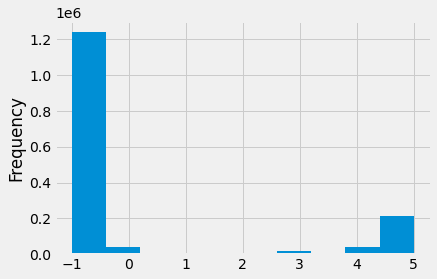

In [4]:
print((df.rating < 0).sum(), (df.rating > 5).sum())
df.rating.fillna(-1).plot(kind='hist');

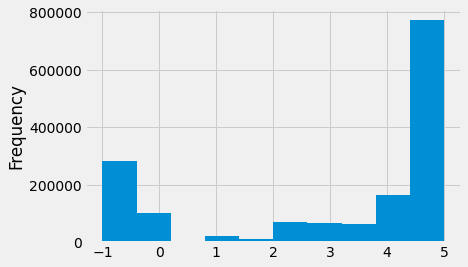

In [5]:
df['rating_user_mean'] = df.groupby('user_id').rating.transform(np.mean)
df['rating_fillna_user_mean'] = np.where(df.rating.isna(), df.rating_user_mean, df.rating)
df.rating_fillna_user_mean.fillna(-1).plot(kind='hist');

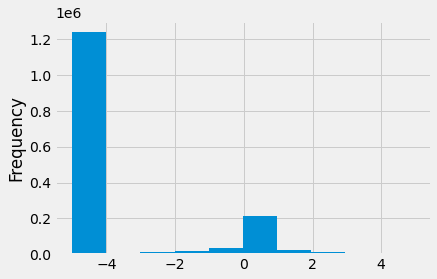

In [6]:
# например, пользователь всем книгам ставит оценку не больше 3, его 3 сопоставима с 5. Уровняем такие разницы вычев среднее по пользователю
df['rating_norm_by_user'] = df.rating  - df.groupby('user_id').rating.transform(np.mean)
df.rating_norm_by_user.fillna(-5).plot(kind='hist');

In [7]:
(df.progress == 0).sum()/ df.shape[0],\
((df.progress == 0) & (df.rating.notna())).sum()/df.shape[0]

(0.12993622420408255, 0.004951024156722698)

In [8]:
df['progress0_rating_na'] = (df.progress == 0) & (df.rating.notna())

In [9]:
print((df.progress < 0).sum(), (df.progress > 100).sum())
df.progress = df.progress.clip(upper=100)

0 1


In [10]:
df.isna().sum()/df.shape[0]

user_id                    0.00000
item_id                    0.00000
progress                   0.00000
rating                     0.79292
start_date                 0.00000
rating_user_mean           0.18155
rating_fillna_user_mean    0.18155
rating_norm_by_user        0.79292
progress0_rating_na        0.00000
dtype: float64

In [11]:
df['progress'] = df['progress'].astype(np.int8)
df['rating'] = df['rating'].astype(pd.SparseDtype(np.float32, np.nan))
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1562505 entries, 0 to 1562504
Data columns (total 9 columns):
 #   Column                   Non-Null Count    Dtype               
---  ------                   --------------    -----               
 0   user_id                  1562505 non-null  int64               
 1   item_id                  1562505 non-null  int64               
 2   progress                 1562505 non-null  int8                
 3   rating                   323563 non-null   Sparse[float32, nan]
 4   start_date               1562505 non-null  datetime64[ns]      
 5   rating_user_mean         1278832 non-null  float64             
 6   rating_fillna_user_mean  1278832 non-null  float64             
 7   rating_norm_by_user      323563 non-null   float64             
 8   progress0_rating_na      1562505 non-null  bool                
dtypes: Sparse[float32, nan](1), bool(1), datetime64[ns](1), float64(3), int64(2), int8(1)
memory usage: 77.0 MB


### Users

In [12]:
display(df_users, df_users.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137254 entries, 0 to 137253
Data columns (total 3 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   user_id  137254 non-null  int64  
 1   age      137244 non-null  object 
 2   sex      135640 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 3.1+ MB


,user_id,age,sex
0,0,45_54,1.0
1,1,25_34,0.0
2,2,45_54,0.0
3,3,65_inf,0.0
4,4,18_24,0.0
...,...,...,...
137249,166060,25_34,0.0
137250,166061,35_44,1.0
137251,166062,45_54,1.0
137252,166065,25_34,0.0


None

In [13]:
df_users.nunique()

user_id    137254
age             6
sex             2
dtype: int64

In [14]:
def add_nan_to_cat(df_user, feature):
    if df_users[feature].isna().sum() != 0:
        df_users[feature] = df_users[feature].astype('category').cat.add_categories(feature+'_nan')
        df_users[feature] = df_users[feature].fillna(feature+'_nan')
        
        
def compate_dfs_by_id(df, df_users, feature_id):
    interaction_users = df[feature_id].unique()
    users = df_users[feature_id].unique()

    common_users = len(np.intersect1d(interaction_users, users))
    users_only_interaction = len(np.setdiff1d(interaction_users, users))
    users_only_features = len(np.setdiff1d(users, interaction_users))
    total_users = common_users + users_only_features + users_only_interaction

    print(f'Кол-во пользователей - {total_users}')
    print(f'Кол-во пользователей cвзаимодействиями и фичами - {common_users} ({common_users / total_users * 100:.2f}%)')
    print(f'Кол-во пользователей только c взаимодействиями - {users_only_interaction} ({users_only_interaction / total_users * 100:.2f}%)')
    print(f'Кол-во пользователей только c фичами - {users_only_features} ({users_only_features / total_users * 100:.2f}%)')

In [15]:
compate_dfs_by_id(df, df_users, 'user_id')

Кол-во пользователей - 164771
Кол-во пользователей cвзаимодействиями и фичами - 130808 (79.39%)
Кол-во пользователей только c взаимодействиями - 27517 (16.70%)
Кол-во пользователей только c фичами - 6446 (3.91%)


In [16]:
# добавим пользователей в df_users, если они есть в interection df
new_users = np.setdiff1d(df.user_id.unique(), df_users.user_id.unique())
df_users = df_users.append(pd.DataFrame(new_users, columns=['user_id']))
assert df_users.user_id.nunique() >= df.user_id.nunique()
df_users

,user_id,age,sex
0,0,45_54,1.0
1,1,25_34,0.0
2,2,45_54,0.0
3,3,65_inf,0.0
4,4,18_24,0.0
...,...,...,...
27512,166004,NaN,NaN
27513,166023,NaN,NaN
27514,166055,NaN,NaN
27515,166063,NaN,NaN


In [17]:
df_users.isna().sum()/df_users.shape[0]

user_id    0.000000
age        0.167062
sex        0.176797
dtype: float64

In [18]:
add_nan_to_cat(df_users, 'age')
add_nan_to_cat(df_users, 'sex')
df_users.isna().sum(), df_users.dtypes

(user_id    0
 age        0
 sex        0
 dtype: int64,
 user_id       int64
 age        category
 sex        category
 dtype: object)

### Items

In [19]:
display(df_items.head(), df_items.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 63758 entries, 0 to 63757
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   id       63758 non-null  int64 
 1   title    63758 non-null  object
 2   genres   63753 non-null  object
 3   authors  56700 non-null  object
 4   year     49508 non-null  object
dtypes: int64(1), object(4)
memory usage: 2.4+ MB


,id,title,genres,authors,year
0,248031,Ворон-челобитчик,"Зарубежные детские книги,Сказки,Зарубежная кла...",Михаил Салтыков-Щедрин,1886
1,256084,Скрипка Ротшильда,"Классическая проза,Литература 19 века,Русская ...",Антон Чехов,1894
2,134166,Испорченные дети,"Зарубежная классика,Классическая проза,Литерат...",Михаил Салтыков-Щедрин,1869
3,281311,Странный человек,"Пьесы и драматургия,Литература 19 века",Михаил Лермонтов,1831
4,213473,Господа ташкентцы,"Зарубежная классика,Классическая проза,Литерат...",Михаил Салтыков-Щедрин,1873


None

In [20]:
df_items.year.value_counts().tail()

450–399 г. до н.э.    1
1977, 1986            1
1667                  1
2012-2013             1
I в. до н. э.         1
Name: year, dtype: int64

In [21]:
def num_bytes_format(num_bytes, float_prec=4):
    units = ['bytes', 'Kb', 'Mb', 'Gb', 'Tb', 'Pb', 'Eb']
    for unit in units[:-1]:
        if abs(num_bytes) < 1000:
            return f'{num_bytes:.{float_prec}f} {unit}'
        num_bytes /= 1000
    return f'{num_bytes:.4f} {units[-1]}'

In [22]:
num_bytes = df_items.memory_usage(deep=True).sum()
num_bytes_format(num_bytes)

'30.0965 Mb'

In [23]:
df_items.nunique(), df_items.shape

(id         63758
 title      58093
 genres     11091
 authors    17024
 year        1074
 dtype: int64,
 (63758, 5))

In [24]:
df_items.head()

,id,title,genres,authors,year
0,248031,Ворон-челобитчик,"Зарубежные детские книги,Сказки,Зарубежная кла...",Михаил Салтыков-Щедрин,1886
1,256084,Скрипка Ротшильда,"Классическая проза,Литература 19 века,Русская ...",Антон Чехов,1894
2,134166,Испорченные дети,"Зарубежная классика,Классическая проза,Литерат...",Михаил Салтыков-Щедрин,1869
3,281311,Странный человек,"Пьесы и драматургия,Литература 19 века",Михаил Лермонтов,1831
4,213473,Господа ташкентцы,"Зарубежная классика,Классическая проза,Литерат...",Михаил Салтыков-Щедрин,1873


In [25]:
df_items['genres']

0        Зарубежные детские книги,Сказки,Зарубежная кла...
1        Классическая проза,Литература 19 века,Русская ...
2        Зарубежная классика,Классическая проза,Литерат...
3                   Пьесы и драматургия,Литература 19 века
4        Зарубежная классика,Классическая проза,Литерат...
                               ...                        
63753    Эротические романы,Любовно-фантастические рома...
63754                          Современные любовные романы
63755                                Современные детективы
63756    Зарубежные детективы,Исторические детективы,За...
63757                                     Любовное фэнтези
Name: genres, Length: 63758, dtype: object

In [51]:
user_to_lib = {}

In [ ]:
grouped = df.groupby

### Test/ to_submit

In [26]:
TEST_N_DAY = 2 # надо будет предсказать наблюедния за 2 дня, сохраним этот параметр для валидации
TOP_N = 10

# Validation

In [27]:
CV_FOLDS = 7
class TimeRangeSplit():
    """
        https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.date_range.html
    """
    def __init__(self, 
                 start_date, 
                 end_date=None, 
                 freq='D', 
                 periods=None, 
                 tz=None, 
                 normalize=False, 
                 closed=None, 
                 train_min_date=None,
                 filter_cold_users=True, 
                 filter_cold_items=True, 
                 filter_already_seen=True):
        
        self.start_date = start_date
        if end_date is None and periods is None:
            raise ValueError("Either 'end_date' or 'periods' must be non-zero, not both at the same time.")

        self.end_date = end_date
        self.freq = freq
        self.periods = periods
        self.tz = tz
        self.normalize = normalize
        self.closed = closed
        self.train_min_date = pd.to_datetime(train_min_date, errors='raise')
        self.filter_cold_users = filter_cold_users
        self.filter_cold_items = filter_cold_items
        self.filter_already_seen = filter_already_seen

        self.date_range = pd.date_range(
            start=start_date, 
            end=end_date, 
            freq=freq, 
            periods=periods, 
            tz=tz, 
            normalize=normalize, 
            closed=closed)
        
        print(self.date_range)

        self.max_n_splits = max(0, len(self.date_range) - 1)
        if self.max_n_splits == 0:
            raise ValueError("Provided parametrs set an empty date range.") 

    def split(self, 
              df, 
              user_column='user_id',
              item_column='item_id',
              datetime_column='date',
              fold_stats=False):
        df_datetime = df[datetime_column]
        if self.train_min_date is not None:
            train_min_mask = df_datetime >= self.train_min_date
        else:
            train_min_mask = df_datetime.notnull()
        date_range = self.date_range[(self.date_range >= df_datetime.min()) & 
                                     (self.date_range <= df_datetime.max())]
        
        for start, end in pairwise(date_range):
            fold_info = {
                'Start date': start,
                'End date': end
            }
            train_mask = train_min_mask & (df_datetime < start)
            train_idx = df.index[train_mask]
            if fold_stats:
                fold_info['Train'] = len(train_idx)

            test_mask = (df_datetime >= start) & (df_datetime < end)
            test_idx = df.index[test_mask]
            
            if self.filter_cold_users:
                new = np.setdiff1d(
                    df.loc[test_idx, user_column].unique(), 
                    df.loc[train_idx, user_column].unique())
                new_idx = df.index[test_mask & df[user_column].isin(new)]
                test_idx = np.setdiff1d(test_idx, new_idx)
                test_mask = df.index.isin(test_idx)
                if fold_stats:
                    fold_info['New users'] = len(new)
                    fold_info['New users interactions'] = len(new_idx)

            if self.filter_cold_items:
                new = np.setdiff1d(
                    df.loc[test_idx, item_column].unique(), 
                    df.loc[train_idx, item_column].unique()) # not in train
                new_idx = df.index[test_mask & df[item_column].isin(new)]
                test_idx = np.setdiff1d(test_idx, new_idx) # in train
                test_mask = df.index.isin(test_idx)
                if fold_stats:
                    fold_info['New items'] = len(new)
                    fold_info['New items interactions'] = len(new_idx)

            if self.filter_already_seen:
                user_item = [user_column, item_column]
                train_pairs = df.loc[train_idx, user_item].set_index(user_item).index
                test_pairs = df.loc[test_idx, user_item].set_index(user_item).index
                intersection = train_pairs.intersection(test_pairs)
                test_idx = test_idx[~test_pairs.isin(intersection)] # exclude intersection
                if fold_stats:
                    fold_info['Known interactions'] = len(intersection)

            if fold_stats:
                fold_info['Test'] = len(test_idx)

            yield (train_idx, test_idx, fold_info)

    def get_n_splits(self, df, datetime_column='date'):
        df_datetime = df[datetime_column]
        if self.train_min_date is not None:
            df_datetime = df_datetime[df_datetime >= self.train_min_date]

        date_range = self.date_range[(self.date_range >= df_datetime.min()) & 
                                     (self.date_range <= df_datetime.max())]

        return max(0, len(date_range) - 1)

In [28]:
df.sort_values('start_date', inplace=True)

start_date = df['start_date'].max().normalize() - pd.Timedelta(days=CV_FOLDS) * TEST_N_DAY # количество фолом по 2 дня в каждом
cv = TimeRangeSplit(start_date=start_date, periods=CV_FOLDS+1, freq=f'{TEST_N_DAY}d', 
                    filter_cold_users=False) # в тесте есть новые наблюдения, поэтому для корреляции валидации и теста оставим новые наблюдения в валидации
next(cv.split(df, datetime_column='start_date'));

DatetimeIndex(['2019-12-17', '2019-12-19', '2019-12-21', '2019-12-23',
               '2019-12-25', '2019-12-27', '2019-12-29', '2019-12-31'],
              dtype='datetime64[ns]', freq='2D')


In [29]:
cvs = list(cv.split(
    df, 
    user_column='user_id',
    item_column='item_id',
    datetime_column='start_date',
    fold_stats=True
))

folds_info_with_stats = pd.DataFrame([info for _, _, info in cvs])
folds_info_with_stats

,Start date,End date,Train,New items,New items interactions,Known interactions,Test
0,2019-12-17,2019-12-19,1530985,0,0,0,4190
1,2019-12-19,2019-12-21,1535175,0,0,0,4284
2,2019-12-21,2019-12-23,1539459,0,0,0,4228
3,2019-12-23,2019-12-25,1543687,0,0,0,4119
4,2019-12-25,2019-12-27,1547806,0,0,0,4232
5,2019-12-27,2019-12-29,1552038,0,0,0,4204
6,2019-12-29,2019-12-31,1556242,0,0,0,4189


In [30]:
for train_idx, val_idx, _ in cv.split(df.sort_values('start_date'), datetime_column='start_date'):
    train, val = df.loc[train_idx], df.loc[val_idx]
    print(train.shape, train.user_id.nunique(), end='\t')
    print(val.shape, val.user_id.nunique(), end='\n------------\n')

(1530985, 9) 158289	(4190, 9) 3128
------------
(1535175, 9) 158295	(4284, 9) 3317
------------
(1539459, 9) 158296	(4228, 9) 3161
------------
(1543687, 9) 158299	(4119, 9) 2928
------------
(1547806, 9) 158306	(4232, 9) 3220
------------
(1552038, 9) 158314	(4204, 9) 3148
------------
(1556242, 9) 158318	(4189, 9) 3200
------------


In [31]:
submit.shape, submit.Id.nunique()

((3074, 2), 3074)

In [32]:
train_idx, val_idx, _ = cvs[0]
train, val = df.loc[train_idx], df.loc[val_idx]

print(train.start_date.max(), val.start_date.min())
assert folds_info_with_stats['Train'][0] == train.shape[0]
assert folds_info_with_stats['Test'][0] == val.shape[0]
train.head()

2019-12-16 00:00:00 2019-12-17 00:00:00


,user_id,item_id,progress,rating,start_date,rating_user_mean,rating_fillna_user_mean,rating_norm_by_user,progress0_rating_na
0,90133,82910,100,NaN,2018-01-01,4.444444,4.444444,NaN,False
1483,74248,240559,100,NaN,2018-01-01,4.756757,4.756757,NaN,False
1482,19500,312792,27,NaN,2018-01-01,0.000000,0.000000,NaN,False
1481,82378,297929,92,NaN,2018-01-01,1.000000,1.000000,NaN,False
1480,160917,390293,85,5.0,2018-01-01,5.000000,5.000000,0.0,False


# Popular model

In [33]:
def metrics_map(val, recs):
    users_count = val.user_id.nunique()

    recs = recs.explode('item_id')
    recs['rank'] = recs.groupby('user_id').cumcount() + 1

    val_recs = val.set_index(['user_id', 'item_id']).join(recs.set_index(['user_id', 'item_id']))
    val_recs = val_recs.sort_values(by=['user_id', 'rank'])
    val_recs['users_item_count'] = val_recs.groupby(['user_id'], sort=False)['rank'].transform(np.size)

    val_recs['cumulative_rank'] = val_recs.groupby(level='user_id').cumcount() + 1
    val_recs['cumulative_rank'] = val_recs['cumulative_rank'] / val_recs['rank']

    mapN = (val_recs["cumulative_rank"] / val_recs["users_item_count"]).sum() / users_count
    print(f"MAP@{TOP_N} = {mapN}")
    return mapN

In [34]:
class PopularRecommender():
    def __init__(self, max_K=100, days=30, user_column='user_id', item_column='item_id', dt_column='date',
                groupby=None, fit_na_as_common=True):
        self.max_K = max_K
        self.days = days
        self.user_column = user_column
        self.item_column = item_column
        self.dt_column = dt_column
        self.groupby = groupby
        self.fit_na_as_common = fit_na_as_common
        self.recommendations = []
        
    def fit(self, df, df_users=None):
        min_date = df[self.dt_column].max().normalize() - pd.DateOffset(days=self.days)
        data = df[df[self.dt_column] > min_date]
        recomm_common = data[self.item_column].value_counts().head(self.max_K).index.values
        self.recomm_common = recomm_common
        self.df_users = df_users
        
        if self.groupby is not None:
            if df_users is None:
                print('No df_users')
                return None
            
            data = data.merge(df_users, on=self.user_column, how='left')
            self.recommendations = data.groupby(self.groupby)[self.item_column]\
                                       .apply(lambda x: x.value_counts().head(self.max_K).index.values)
            # если нет записей для рекомендации, рекомендовать общее
            na_mask = self.recommendations.isna()
            self.recommendations[na_mask] = self.recommendations[na_mask].apply(lambda x: recomm_common)
            # на случай, если список рекомендаций будет коротким (например только 2 книги)
            # добавим общую рекоменацию
            self.recommendations = self.recommendations.apply(lambda x: np.concatenate((x, recomm_common)))
            # na в категориях
            if self.fit_na_as_common:
                na_mask = (self.recommendations.reset_index()[self.groupby]=='nan').sum(axis=1)!=0
                self.recommendations[na_mask.values] = self.recommendations[na_mask.values].apply(lambda x: recomm_common)
        else:
            self.recommendations = recomm_common
        
    def recommend(self, users=None, N=10):
        recs = self.recommendations[:N]
        
        if users is None:
            if self.groupby is not None:
                print('For recomendations based on groupby needs used_id')
                return None
            return recs
        else:
            if self.groupby is not None:
                recoms = self.recommendations.apply(lambda x: x[:N]) # только N первых рекомендаций
                recoms = recoms.reset_index()
                recoms[self.groupby] = recoms[self.groupby].astype('category')
                data = users.to_frame().merge(self.df_users, on=self.user_column, how='left') # добавляем информацию по пользователям для разбиения на группы
                data = data.merge(recoms, on=self.groupby, how='left') # добавляем рекомендации в соответсвии с группой
                # если встречается уникальная группа, то пресказания будут пропусками. Заполнить их общими предсказаниями по всему набору
                na_mask = data.iloc[:, -1].isna()
                data.iloc[:, -1][na_mask] = data.iloc[:, -1][na_mask].apply(lambda x: self.recomm_common[:N])

                return data.iloc[:, -1].values.tolist()
            
            else: # если не было разбиения на группы
                return list(islice(cycle([recs]), len(users))) # возвращаем общее предсказание

## Cross-val

In [35]:
def model_Popular_cv(model):
    metrics = []
    for train_idx, val_idx, _ in cvs:
        train, val = df.loc[train_idx], df.loc[val_idx]

        model.fit(train, df_users)

        recs = pd.DataFrame({'user_id': val['user_id'].unique()})
        recs['item_id'] = model.recommend(recs['user_id'], N=TOP_N)

        metrics.append(metrics_map(val, recs))

    map_mean = np.mean(metrics)
    print(f'mean MAP@10 = {map_mean}')
    print(f'std MAP@10 = {np.std(metrics)}')
    
    return metrics

def model_Popular_to_submit(model, name=''):
    model.fit(df, df_users)

    user_id = submit['Id'].copy()
    user_id.rename('user_id',inplace=True)
    recs = model.recommend(user_id, N=TOP_N)
    submit['Predicted'] = recs
    submit['Predicted'] = submit.Predicted.apply(lambda x: ' '.join(map(str, x)) if x is not np.nan else '')
    submit.to_csv(f'submit{name}.csv', index=False)
    return submit

In [36]:
pd.options.mode.chained_assignment = None  # default='warn'

In [37]:
# results = []
# for days in tqdm(range(21, 33)):
#     params['days'] = days
#     model = PopularRecommender(**params)
#     metrics = model_Popular_cv(model, temp, drop_known=True)
#     to_add = dict(days=days, 
#                   map_mean = np.mean(metrics),
#                   map_std=np.std(metrics))
#     results.append(to_add)
    
# pd.DataFrame(results).sort_values('map_mean', ascending=False)

In [38]:
params = dict(groupby=None,
              fit_na_as_common=False,
              days = 21)

model = PopularRecommender(dt_column='start_date', 
                           **params)
metrics = model_Popular_cv(model)

MAP@10 = 0.01095725880932083
MAP@10 = 0.007906910528255116
MAP@10 = 0.010772809565913014
MAP@10 = 0.012641999965190755
MAP@10 = 0.011057441092378979
MAP@10 = 0.017405029144228635
MAP@10 = 0.011669890873015874
mean MAP@10 = 0.01177304856832903
std MAP@10 = 0.0026621696748790587


In [40]:
model = PopularRecommender(days= 21 , groupby=None, dt_column='start_date')
model.fit(df, df_users)

## BM25Recommender model

In [41]:
users_inv_mapping = dict(enumerate(df['user_id'].unique()))
users_mapping = {v: k for k, v in users_inv_mapping.items()}

items_inv_mapping = dict(enumerate(df['item_id'].unique()))
items_mapping = {v: k for k, v in items_inv_mapping.items()}

item_titles = pd.Series(df_items['title'].values, index=df_items['id']).to_dict()

len(users_mapping), len(items_mapping)

(158325, 63758)

In [42]:
def get_coo_matrix(df, 
                   user_col='user_id', 
                   item_col='item_id', 
                   weight_col=None, 
                   users_mapping=users_mapping, 
                   items_mapping=items_mapping):
    if weight_col is None:
        weights = np.ones(len(df), dtype=np.float32)
    else:
        weights = df[weight_col].astype(np.float32)

    interaction_matrix = sp.coo_matrix((
        weights, 
        (
            df[user_col].map(users_mapping.get), 
            df[item_col].map(items_mapping.get)
        )
    ))
    return interaction_matrix

In [43]:
train_mat = get_coo_matrix(train).tocsr()
assert train_mat.shape == (train['user_id'].map(users_mapping.get).max()+1,
                    train['item_id'].map(items_mapping.get).max()+1)
train_mat

<158289x63758 sparse matrix of type '<class 'numpy.float32'>'
	with 1530985 stored elements in Compressed Sparse Row format>

In [44]:
mat = get_coo_matrix(df).tocsr()

In [45]:
from implicit.nearest_neighbours import BM25Recommender

In [46]:
model = BM25Recommender(K=10)
model.fit(mat.T) # 

  0%|          | 0/63758 [00:00<?, ?it/s]

In [47]:
# для новых наблюдений будем использовать общепопулярную рекомендацию, без группировки соотвественно
pop_model = PopularRecommender(days=21, dt_column='start_date')
pop_model.fit(df, df_users)
recomm_mapper = pop_model.recomm_common

In [48]:
def generate_implicit_recs_mapper(model, train_matrix, N, user_mapping, item_inv_mapping, recomm_mapper, thres=20):
    def _recs_mapper(user):
        try:
            user_id = user_mapping[user]
        except KeyError:
            return recomm_mapper[:N]
        if user in user_to_lib.keys() and len(user_to_lib[user]) < thres:
            return recomm_mapper[:N]
        if user_id >= train_matrix.shape[0]:
            return recomm_mapper[:N]
        else:
            recs = model.recommend(user_id, 
                               train_matrix, 
                               N=N, 
                               filter_already_liked_items=True)
        return [item_inv_mapping[item] for item, _ in recs]
    return _recs_mapper

def generate_implicit_recs_mapper_submit(model, train_matrix, N, user_mapping, item_inv_mapping, recomm_mapper, thres=20):
    def _recs_mapper(user):
        try:
            user_id = user_mapping[user]
        except KeyError:
            return recomm_mapper[:N]
        if user in user_to_lib.keys() and len(user_to_lib[user]) < thres:
            return recomm_mapper[:N]
        if user_id >= train_matrix.shape[0]:
            return recomm_mapper[:N]
        else:
            recs = model.recommend(user_id, 
                               train_matrix, 
                               N=N, 
                               filter_already_liked_items=True)
        return [item_inv_mapping[item] for item, _ in recs]
    return _recs_mapper

In [49]:
mapper = generate_implicit_recs_mapper(model, mat, 10, 
                                       users_mapping, items_inv_mapping, recomm_mapper, thres=10)


In [50]:
submit['Predicted'] = submit['Id'].map(mapper)

NameError: name 'user_to_lib' is not defined

In [ ]:
submit['Predicted'] = submit.Predicted.apply(lambda x: ' '.join(map(str, x)) if x is not np.nan else '')

In [ ]:
submit.to_csv('ensemble.csv', index=False)

In [ ]:
submit

In [ ]:
submit